# Machine Learning with PyTorch

## Understanding PyTorch

* Tensors and NumPy interfaces
* Autograd
* Using GPUs with `torch.cuda`
* Parallelizing on clusters with `torch.distributed`
* Create a neural network with `torch.nn`

## Tensors and NumPy interfaces

At a first pass, PyTorch tensors are very similar to NumPy arrays.  Both are ways of storing multi-dimensional data efficiently, and much of the same "vectorized" style of operation applies to both. Broadcasting and elementwise operations are similar.  Moreover, many of the same functions and methods exist in both PyTorch and NumPy, and conversion between the two formats is made straightforward by PyTorch.

Where PyTorch tensors go beyond NumPy arrays, and are needed for neural networks are in a couple key areas.  As a not-so-minor matter, tensors can work transparently on GPUs as well as CPUs, and this can often vastly speed up operations.  NumPy does not build in that capability, but a number of projects allow this particular capability to be used outside of PyTorch, in varying ways (see [PyCUDA](https://documen.tician.de/pycuda/array.html), [Numba](https://numba.pydata.org/numba-doc/dev/cuda/index.html), [CuPy](https://cupy.chainer.org/), [MXNet](https://mxnet.incubator.apache.org/versions/master/tutorials/basic/ndarray.html), and probably others).

You *could* use PyTorch simply to work with array computation on GPUs, but what is more likely to bring you here is an equally essential capability that is not present in those other mentioned libraries (by design): Autograd.  By storing the gradients from every operation (where autograd is enabled for any component tensors), PyTorch provides reverse automatic differentiation.  That is to say, it gives you a directed acyclic graph whose leaves are the input tensors and roots are the output tensors.  We explain this more below.

## Autograd

Remember that a derivative is only the *slope* of a curve, not its offset.

In [1]:
import torch
from torch.autograd import Variable
import numpy as np

x = torch.randn(3, 3, requires_grad=True)
print("Random 2-D tensor")
print(x)

# Perform an operation on tensor
y = (x + 7) * 5
print("\nRandom 2-D shifted by 7, multiplied by 5")
print(y)

Random 2-D tensor
tensor([[-0.1671,  2.2173,  1.8600],
        [-0.3152, -0.0601, -1.4995],
        [ 0.4635,  0.2840,  0.0924]], requires_grad=True)

Random 2-D shifted by 7, multiplied by 5
tensor([[34.1646, 46.0866, 44.2998],
        [33.4239, 34.6994, 27.5025],
        [37.3175, 36.4199, 35.4619]], grad_fn=<MulBackward0>)


In [2]:
v = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]], dtype=torch.float)

# grad_fn is derivative, so offset does not matter to slope
y.grad_fn(v)

(tensor([[ 5., 10., 15.],
         [20., 25., 30.],
         [35., 40., 45.]]),
 None)

In [3]:
# Perform an additional vectorized operation, then a reduction
z = y * 3
out = z.mean()

print("Multiplied by 3")
print(z)
print("\nMean of values")
print(out)

Multiplied by 3
tensor([[102.4939, 138.2597, 132.8994],
        [100.2718, 104.0982,  82.5074],
        [111.9526, 109.2598, 106.3857]], grad_fn=<MulBackward0>)

Mean of values
tensor(109.7920, grad_fn=<MeanBackward0>)


In [4]:
grad = out.grad_fn
indent = 1
while True:
    print(" "*indent, "-->", grad)
    if not grad.next_functions:
        break
    grad = grad.next_functions[0][0]
    indent += 1

  --> <MeanBackward0 object at 0x7fa6f625f810>
   --> <MulBackward0 object at 0x7fa6f625fb50>
    --> <MulBackward0 object at 0x7fa6f625fe90>
     --> <AddBackward0 object at 0x7fa6f6264210>
      --> <AccumulateGrad object at 0x7fa6f6264550>


The semantics of reverse operations are, to be honest, unintuitive in many cases.  

So, for example, the gradient function attached to `out` after the `.mean()` operation is actually just distributing the values over an array of the input shape, but not scaling them to the same proportion as the starting values.  However, the operation *does* remember the input shape used to construct the reduction.

In [5]:
print(out.grad_fn)

val1 = Variable(torch.tensor([10.]))
out.grad_fn(val1)

tensor([[1.1111, 1.1111, 1.1111],
        [1.1111, 1.1111, 1.1111],
        [1.1111, 1.1111, 1.1111]])

In [6]:
val2 = torch.tensor([[3, 6, 9],
                     [1, 2, 3],
                     [2, 4, 8]], dtype=torch.float)
out.grad_fn(val2)

tensor([[0.3333, 0.6667, 1.0000],
        [0.1111, 0.2222, 0.3333],
        [0.2222, 0.4444, 0.8889]])

The result of this gradient function really does have to be 3x3; it's not simply a division by 9, nor a division by an arbitrary size of a tensor.  But because of broadcasting rules—the same as in NumPy, for those familiar with that library—shapes like a scalar or a less-dimensional shape can be broadcast to the target shape.

In [7]:
# 1D of compatible length can be broadcase
val3 = torch.tensor([1.5, 3.33, 9.1])
out.grad_fn(val3)

tensor([[0.1667, 0.3700, 1.0111],
        [0.1667, 0.3700, 1.0111],
        [0.1667, 0.3700, 1.0111]])

In [8]:
# But not this
try:
    val4 = torch.tensor([[1., 2.],
                         [3., 4.]])
    out.grad_fn(val4)
except Exception as err:
    print(err)

The expanded size of the tensor (3) must match the existing size (2) at non-singleton dimension 1.  Target sizes: [3, 3].  Tensor sizes: [2, 2]


For mean in particular, we could easily enough redistribute the magnitude along with the distribution.  But there is no general "go back to the last tensor exactly" function that I know of.

In [9]:
print("Original tensor\n", val2, '\n')

size = np.prod(val2.shape)
print("MeanBackward then rescaled manually\n", out.grad_fn(val2) * size)

Original tensor
 tensor([[3., 6., 9.],
        [1., 2., 3.],
        [2., 4., 8.]]) 

MeanBackward then rescaled manually
 tensor([[3., 6., 9.],
        [1., 2., 3.],
        [2., 4., 8.]])


### A low-level neural network

We do not actually *need* autograd—nor the `torch.nn` package—to implement a neural network.  In fact, we can do it pretty easily in NumPy also.  These more advanced capabilities just make things easier.  The next several examples are lightly adapted from [Justin Johnson's discussion](https://github.com/jcjohnson/pytorch-examples), linked in the resources.  A very similar example appears in numerous places, so I am not sure of the first source of it.

For this task, we will train a two-layer neural network to learn the relationship between 1000 random inputs and 10 random outputs.  In a first version, PyTorch looks almost the same as NumPy. First setup the problem.

The below illustration is of a simpler network than the one we actually create. In the image, a network with a 45 node input layer a 15 node hidden layer, and a 5 node output layer is shown just not to overwhelm as much visually.  Our 1000/100/10 is still a rather simple network by standards of most used in practice, nonetheless.

In the image, a range of colors along the edges show possible weights of the connections.  What is displayed is simply random values, but a real network would be trained to have weights specific to the data and the problem at hand.  Somewhat subtly, the image also shows a bias input to the output layer.  Using this is a good idea, and is not conceptually difficult to implement at a low-level in code like the below, but we omit that for simplicity.

<img src="img/random-perceptron.png"/>

Drawn with [NN-SVG](http://alexlenail.me/NN-SVG/index.html)

In [10]:
import torch

# N is training set size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N = 64
D_in = 1000
H = 100
D_out = 10
epochs = 501

# The input and output tensors
## The `requires_grad` argument relevant to 2nd example, harmless for 1st
x = torch.randn(N, D_in, dtype=torch.float, requires_grad=False)
y = torch.randn(N, D_out, dtype=torch.float, requires_grad=False)

### Without autograd

The basic array/tensor version:

In [11]:
# Randomly initialize weights
w1 = torch.randn(D_in, H)   # E.g. 1000 x 100 weights
w2 = torch.randn(H, D_out)  # E.g. 100 x 10 weight

learning_rate = 1e-6

for t in range(epochs):
    # Forward pass: compute predicted y
    h = x.mm(w1)             # Spelled `x.dot(w1)` or `x @ w1` in NumPy
    h_relu = h.clamp(min=0)  # Activation function
    y_predict = h_relu.mm(w2)

    # Compute and print loss; loss is a scalar, and is stored in a PyTorch Tensor;
    # we can get its single value as a Python number with loss.item().
    loss = (y_predict - y).pow(2).sum()  # mean squared error
    if not t % 50:
        print("Iteration: %4d - Loss: %0.2e" % (t, loss.item()))
        
    # Backprop to compute gradients of w1 and w2 with respect to loss
    ## Notice that name `loss` is not directly used in backprop
    grad_y_predict = 2.0 * (y_predict - y)
    w2_grad = h_relu.t().mm(grad_y_predict)
    grad_h_relu = grad_y_predict.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0        # Equivalent to `clamp(min=0)`
    w1_grad = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * w1_grad
    w2 -= learning_rate * w2_grad

Iteration:    0 - Loss: 3.75e+07
Iteration:   50 - Loss: 2.13e+04
Iteration:  100 - Loss: 1.24e+03
Iteration:  150 - Loss: 1.38e+02
Iteration:  200 - Loss: 2.05e+01
Iteration:  250 - Loss: 3.45e+00
Iteration:  300 - Loss: 6.12e-01
Iteration:  350 - Loss: 1.12e-01
Iteration:  400 - Loss: 2.08e-02
Iteration:  450 - Loss: 4.20e-03
Iteration:  500 - Loss: 1.05e-03


### Using autograd

The above example works fine, and is not too difficult.  But we *did* need to perform the backward propagation on each "layer" (tensor of weights) manually.  For tens or hundreds of layers this gets awkward and more error prone.  By utilizing autograd, we automatically define a computational graph, and can back propagate a loss function automatically.

In [12]:
w1 = torch.randn(D_in, H, dtype=torch.float, requires_grad=True)
w2 = torch.randn(H, D_out, dtype=torch.float, requires_grad=True)

for t in range(epochs):
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.    
    y_predict = x.mm(w1).clamp(min=0).mm(w2)   # <- ReLU in here

    # Compute and print loss
    loss = (y_predict - y).pow(2).sum()
    if not t % 50:
        print("Iteration: %4d - Loss: %0.3e" % (t, loss.item()))

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.    
    loss.backward()

    # Update weights using gradient descent. For this step we just want to mutate
    # the values of w1 and w2 in-place; we don't want to build up a computational
    # graph for the update steps, so we use the torch.no_grad() context manager
    # to prevent PyTorch from building a computational graph for the updates
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after running the backward pass
        w1.grad.zero_()
        w2.grad.zero_()

Iteration:    0 - Loss: 4.322e+07
Iteration:   50 - Loss: 1.048e+04
Iteration:  100 - Loss: 4.126e+02
Iteration:  150 - Loss: 3.386e+01
Iteration:  200 - Loss: 3.697e+00
Iteration:  250 - Loss: 4.618e-01
Iteration:  300 - Loss: 6.232e-02
Iteration:  350 - Loss: 9.040e-03
Iteration:  400 - Loss: 1.618e-03
Iteration:  450 - Loss: 4.389e-04
Iteration:  500 - Loss: 1.704e-04


## Creating a neural network with `torch.nn`

Most of the time when you want to create a neural network, you will use the higher-level capabilities in `torch.nn`.  Technically, the lower level basic tensor operations, or also autograd, do not require you to design neural networks *per se*.  Any sort of abstract data flow through a computational graph is equally possible.  But the abstraction of arranging clusters neurons in layers, and passing calculation from layer to layer, is a widely used and powerful one.

One difference worth noting between PyTorch and other popular neural network frameworks, is that PyTorch is fully dynamic.  In TensorFlow, you are required compile a model and use it as-is.  In PyTorch, the layers in a network are simply tensors that you can poke at and modify dynamically within your custom code.  Put another way, PyTorch uses eager execution whereas some other libraries lazily define a computational graph in full before they can be used.

In practice, it is a relatively arcane technique to dynamically modify neural networks during training, and we will not cover that specifically in the beginning part of this course.

In [13]:
%%time

# These layers are equivalent to the weight tensors `w1` and `w2`
# Note: nn.Sequential is a Module which contains other Modules, and 
# applies them in sequence to produce its output. Each Linear Module 
# contains internal Tensors for its weight and bias.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )

# The nn package also contains definitions of numerous loss functions; 
# we use Mean Squared Error (MSE) here. Setting `reduction='sum'`  
# computes the *sum* of squared errors rather than their mean; this
# matches the prior examples, but it is more common to use mean
# squared error as a loss by setting reduction='elementwise_mean'.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(epochs):
    # Forward pass: compute predicted y by passing x to the model. Calling the 
    # model requires a Tensor of input data and produces a Tensor of output data.
    y_predict = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_fn(y_predict, y)
    if not t % 50:
        print("Iteration: %4d - Loss: %0.3e" % (t, loss.item()))

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

Iteration:    0 - Loss: 7.363e+02
Iteration:   50 - Loss: 3.569e+01
Iteration:  100 - Loss: 1.933e+00
Iteration:  150 - Loss: 1.858e-01
Iteration:  200 - Loss: 2.464e-02
Iteration:  250 - Loss: 4.037e-03
Iteration:  300 - Loss: 7.703e-04
Iteration:  350 - Loss: 1.642e-04
Iteration:  400 - Loss: 3.803e-05
Iteration:  450 - Loss: 9.348e-06
Iteration:  500 - Loss: 2.393e-06
CPU times: user 7.84 s, sys: 20.2 ms, total: 7.86 s
Wall time: 491 ms


One thing to note.  You can get some basic information about a model simply by printing it or echoing it.  But I—and many other users—like a summary more similar to that Keras provides for other backends.  The external package `torchsummary` provides this, if you'd like it.

In [14]:
model

Sequential(
  (0): Linear(in_features=1000, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

In [15]:
from torchsummary import summary

if not torch.cuda.is_available():
    # torchsummary has a glitch. If a running on a CUDA-enabled build
    # it only wants to print a CUDA model
    summary(model, input_size=(1, D_in))
else:
    # Use this if first doesn't work
    summary(model.to(torch.device('cuda')), input_size=(1, D_in))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]         100,100
              ReLU-2               [-1, 1, 100]               0
            Linear-3                [-1, 1, 10]           1,010
Total params: 101,110
Trainable params: 101,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


### A note on learning rate, bias, and initialization

You may have noticed that we used a much higher learning rate for the built model than we did in the manual gradient cases.  There are a few crucial differences that make these examples not quite identical.  A `torch.nn.Linear` module builds in a few extra abilities that are desirable, but not shown in the simple manual examples.

Of some importance, the initialization of weights is smarter in the linear layer than the simple random numbers in the manual case.  However, most of that difference is probably handled by a few  (dozen) rounds of the training.  More importantly, linear layers add a **bias** term automatically.  This is effectively the constant term in a linear function like `y = ax + b`; our simplest manual network lacks any such term which both makes it succeptible to overfitting and exploding loss.

We can illustrate the relevance of bias to neuron activation with a few simple pictures.  The neural networks we build above used a ReLU activation fuction rather than sigmoid, but the concept and effect is similar in either case.  Let us see the possible responses with and without bias available.

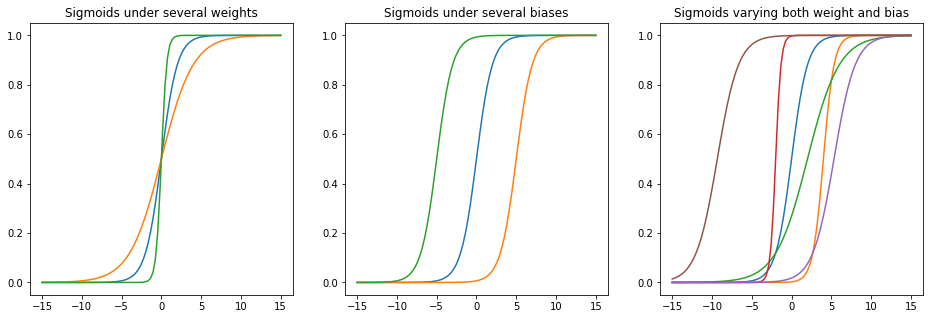

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x, weight=1, bias=0):
    return 1/(1+np.exp(-1 * (x * weight + bias)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
x = np.linspace(-15, 15, 100)
ax1.plot(x, sigmoid(x), x, sigmoid(x, 0.5), x, sigmoid(x, 3.0))
ax1.set_title("Sigmoids under several weights")
ax2.plot(x, sigmoid(x), x, sigmoid(x, bias=-5), x, sigmoid(x, bias=5))
ax2.set_title("Sigmoids under several biases")
ax3.plot(x, sigmoid(x),
         x, sigmoid(x, 1.5, -6), 
         x, sigmoid(x, 0.5, -1), 
         x, sigmoid(x, 3, 6),
         x, sigmoid(x, 0.75, -4),
         x, sigmoid(x, 0.75, 7))
ax3.set_title("Sigmoids varying both weight and bias");

## Using GPUs with `torch.cuda`

Targetting CUDA GPUs is almost trivial under torch.  The only change we need to make is indicating where the tensors live, and the rest of the code works just the same.  Well, at first brush.  Using multiple GPUs or manual memory management of GPUs, or other lower level concerns, require additional work.  But the easy thing is easy, and is likely to speed up fitting considerably.

In [17]:
from time import time

for device in ['cuda', 'cpu']:
    # For demonstration, we can use CPU target if CUDA not available
    if device == 'cuda' and not torch.cuda.is_available():
        continue
    start = time()
    print("Using", device.upper())
    device = torch.device(device)
    
    x = torch.randn(N, D_in, device=device)
    y = torch.randn(N, D_out, device=device)

    # Could use any of the versions shown, but for example:
    loss_fn = torch.nn.MSELoss(reduction='sum')
    learning_rate = 1e-4
    model = torch.nn.Sequential(
              torch.nn.Linear(D_in, H),
              torch.nn.ReLU(),
              torch.nn.Linear(H, D_out),
            ).to(device)

    for t in range(epochs):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        model.zero_grad()
        loss.backward()
        for param in model.parameters():
            param.data -= learning_rate * param.grad

    print("Loss after training:", loss.item())
    print("Time elapsed: %.02f seconds\n" % (time()-start))

Using CUDA
Loss after training: 1.5837546015973203e-05
Time elapsed: 0.46 seconds

Using CPU
Loss after training: 2.24868449549831e-06
Time elapsed: 0.48 seconds



## Parallelizing on clusters with `torch.distributed`

We cannot get into details in this course, but PyTorch includes capabilities to distribute training over a variety of different architectures, including multiple CPUs or multiple GPUs, including on clusters of machines.

The tutorial at [Writing Distributed Applications with PyTorch](https://pytorch.org/tutorials/intermediate/dist_tuto.html) is a good place to get started.

## Next Lesson

**Tasks with Networks**: We just looked at building a few simple networks, in several styles, using PyTorch.  The next lessons delves into more complex and real world examples.

<a href="NetworkExamples_0.ipynb"><img src="img/open-notebook.png" align="left"/></a>